In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp

from sklearn.datasets import make_regression
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

%matplotlib inline

paper: https://arxiv.org/pdf/2106.07263.pdf

In [3]:
np.random.seed(0)

In [53]:
def generate_data(true_effect: float = 0.) -> pd.DataFrame:
    n_samples = 10_000
    k = 5
    
    X, y = make_regression(
        n_samples=n_samples,
        n_features=5,
        noise=40,
    )

    data = pd.DataFrame(X, columns=[f"X_{i}" for i in range(X.shape[1])])
    data["y"] = y
    # treatment indicator
    data["t"] = np.random.randint(0, 2, n_samples)
    # assign each sample into one of the k splits
    data["k"] = np.random.randint(0, k, n_samples)

    treatment_mask = data["t"] == 1
    data.loc[treatment_mask, "y"] += true_effect 

    return data

In [54]:
def train_and_predict(
    data: pd.DataFrame,
    show_r2: bool = False,
) -> tuple[list[BaseEstimator], pd.DataFrame]:

    features = [col for col in data.columns if "X_" in col]
    models = []
    data["g_hat"] = np.nan
    for k in range(data["k"].max() + 1):
        # k-th model is trained on the complement of the k-th split,
        # (all samples that do not belong to the k-th split.
        complement_mask = data["k"] != k
        split_mask = ~complement_mask

        model = LinearRegression()
        model.fit(
            data.loc[complement_mask, features], 
            data.loc[complement_mask, "y"]
        )
        models.append(model)

        # predict the samples in the k-th split
        g_hat = model.predict(data.loc[split_mask, features])
        data.loc[split_mask, "g_hat"] = g_hat

        if show_r2:       
            r2 = r2_score(
                y_true=data.loc[split_mask, "y"],
                y_pred=g_hat
            )
            print(f"model_{k} r2={r2:.2f}")

    return models, data

In [8]:
def compute_ols(data: pd.DataFrame):
    g_bar = data["g_hat"].mean()

    ols_X = pd.DataFrame(
        {
            "X_1": data["t"],
            "X_2": data["g_hat"],
            "X_3": data["t"] * (data["g_hat"] - g_bar)
        }
    )
    ols_y = data["y"]

    ols = LinearRegression()
    ols.fit(ols_X, ols_y)
    return ols

In [47]:
def evaluate(data: pd.DataFrame) -> dict:
    models, data = train_and_predict(data)
    ols = compute_ols(data)

    treatment_mask = data["t"] == 1
    ate = (
        data.loc[treatment_mask, "y"].mean()
        - data.loc[~treatment_mask, "y"].mean()
    )

    return {
        "effect_mlrate_adjusted": ols.coef_[0],
        "effect": ate,
    }

In [64]:
true_effect = 4.
experiments = pd.DataFrame(evaluate(generate_data(true_effect)) for _ in range(1000))

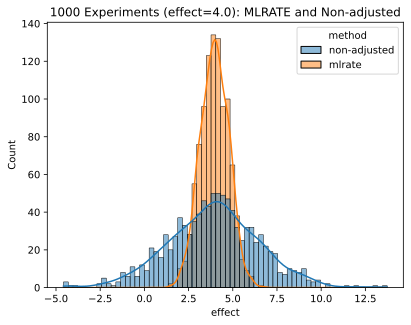

In [65]:
experiments_long = (
    experiments[["effect", "effect_mlrate_adjusted"]]
    .rename(columns={"effect": "non-adjusted", "effect_mlrate_adjusted": "mlrate"})
    .melt(
        value_vars=["non-adjusted", "mlrate"],
        var_name="method",
        value_name="effect"
    )
)

sns.histplot(experiments_long, x="effect", hue="method", kde=True)
plt.title(f"1000 Experiments (effect={true_effect}): MLRATE and Non-adjusted")
plt.show()